# **CLAHE + Bilateral + Normalized + Gamma Correction**

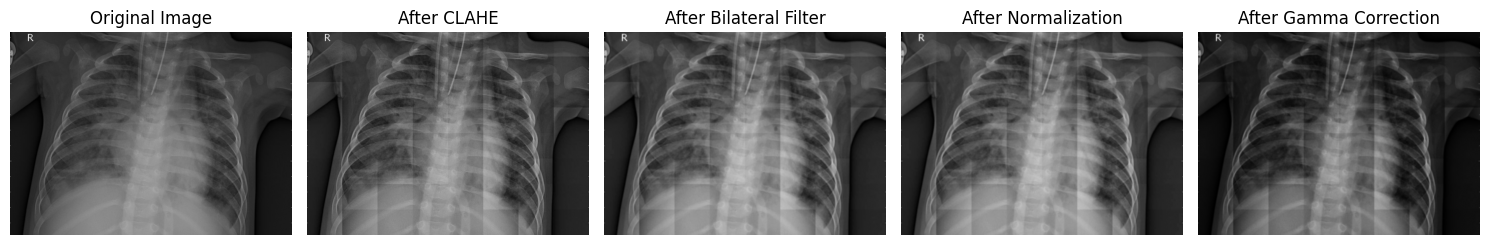

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# ---------- Step 0: Load Image ----------
image = imageio.imread("/content/person80_bacteria_389.jpeg", mode='L')
image = (image / image.max() * 255).astype(np.uint8)

# ---------- Step 1: CLAHE ----------
def clahe_custom(img, tile_grid=(8, 8), clip_limit=40):
    h, w = img.shape
    tile_h, tile_w = h // tile_grid[0], w // tile_grid[1]
    output = np.zeros_like(img)

    for i in range(tile_grid[0]):
        for j in range(tile_grid[1]):
            y1, y2 = i * tile_h, (i + 1) * tile_h
            x1, x2 = j * tile_w, (j + 1) * tile_w
            tile = img[y1:y2, x1:x2]

            hist, _ = np.histogram(tile.flatten(), bins=256, range=[0, 256])
            clipped_hist = np.minimum(hist, clip_limit).astype(np.int32)
            excess = hist - clipped_hist
            redistribute = excess.sum() // 256
            clipped_hist += redistribute

            cdf = clipped_hist.cumsum()
            cdf = 255 * cdf / cdf[-1]
            cdf = cdf.astype('uint8')

            output[y1:y2, x1:x2] = cdf[tile]
    return output

clahe_img = clahe_custom(image)

# ---------- Step 2: Bilateral Filter ----------
def bilateral_filter_custom(img, d=5, sigma_color=75, sigma_space=75):
    assert d % 2 == 1, "Kernel size d must be odd."
    pad = d // 2
    padded = np.pad(img, pad, mode='reflect')
    result = np.zeros_like(img, dtype=float)

    x, y = np.meshgrid(np.arange(-pad, pad + 1), np.arange(-pad, pad + 1))
    spatial_weights = np.exp(-(x**2 + y**2) / (2 * sigma_space**2))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded[i:i + d, j:j + d]
            center = padded[i + pad, j + pad]
            intensity_diff = window - center
            color_weights = np.exp(-(intensity_diff**2) / (2 * sigma_color**2))
            total_weights = color_weights * spatial_weights
            total_weights /= np.sum(total_weights)
            result[i, j] = np.sum(total_weights * window)
    return result.astype(np.uint8)

bilateral_img = bilateral_filter_custom(clahe_img)

# ---------- Step 3: Min-Max Normalization ----------
def min_max_normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

normalized_img = min_max_normalize(bilateral_img)

# ---------- Step 4: Gamma Correction ----------
def gamma_correction(img, gamma):
    return np.power(img, gamma)

gamma = 1.5
gamma_img = gamma_correction(normalized_img, gamma)

# Convert to 8-bit
final_img = (gamma_img * 255).astype(np.uint8)

# ---------- Plot Images at Each Step ----------
titles = [
    "Original Image",
    "After CLAHE",
    "After Bilateral Filter",
    "After Normalization",
    "After Gamma Correction"
]
images = [image, clahe_img, bilateral_img, (normalized_img * 255).astype(np.uint8), final_img]

plt.figure(figsize=(15, 6))
for i in range(len(images)):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# **CLAHE + Bilateral Filtering + Blending + Normalization + Gamma Correction**

**Pneumonia Image**

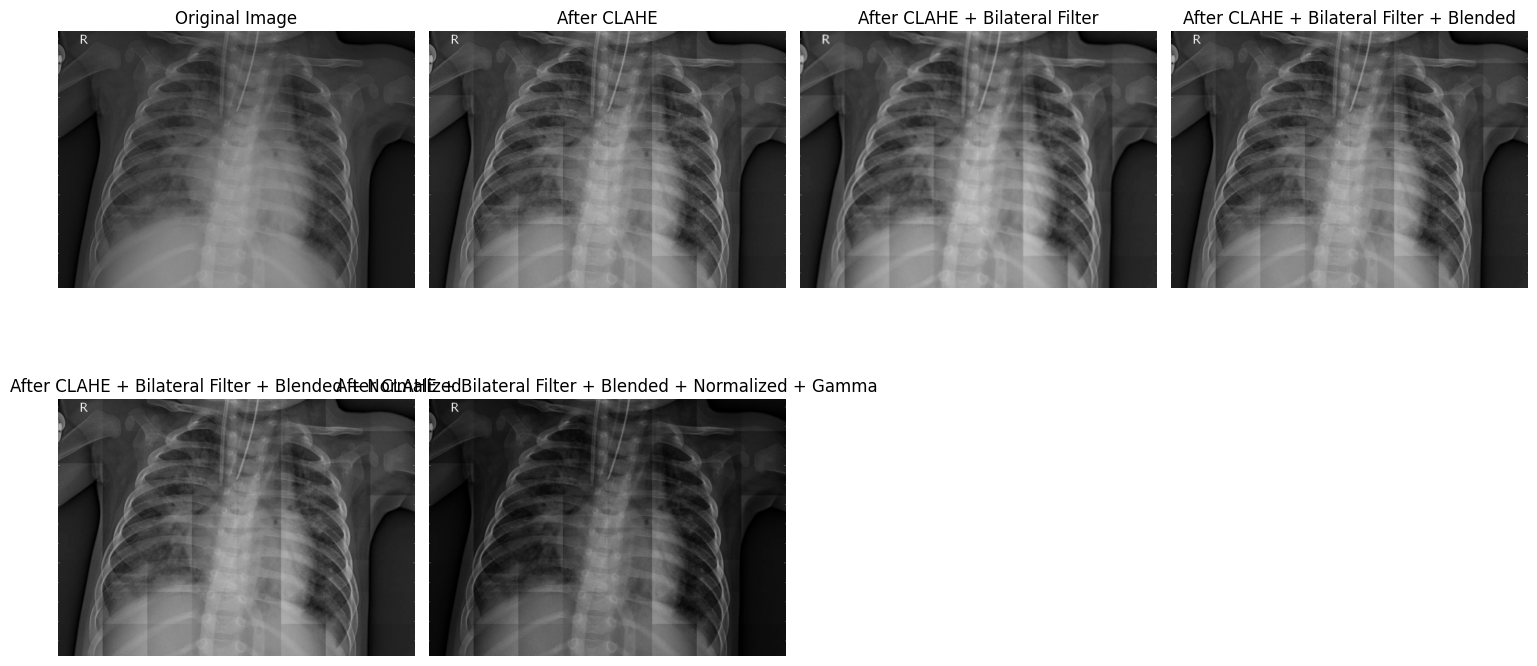

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Suppress deprecation warning

# ---------- Step 0: Load Image ----------
image = imageio.imread("/content/person80_bacteria_389.jpeg", mode='L')
image = (image / image.max() * 255).astype(np.uint8)  # Ensure 8-bit grayscale format

# ---------- Step 1: CLAHE (from scratch) ----------
def clahe_custom(img, tile_grid=(8, 8), clip_limit=40):
    h, w = img.shape
    tile_h, tile_w = h // tile_grid[0], w // tile_grid[1]
    output = np.zeros_like(img)

    for i in range(tile_grid[0]):
        for j in range(tile_grid[1]):
            y1, y2 = i * tile_h, (i + 1) * tile_h
            x1, x2 = j * tile_w, (j + 1) * tile_w
            tile = img[y1:y2, x1:x2]

            hist, _ = np.histogram(tile.flatten(), bins=256, range=[0, 256])

            # Clip histogram
            clipped_hist = np.minimum(hist, clip_limit).astype(np.int32)
            excess = hist - clipped_hist
            redistribute = excess.sum() // 256
            clipped_hist += redistribute

            cdf = clipped_hist.cumsum()
            cdf = 255 * cdf / cdf[-1]
            cdf = cdf.astype('uint8')

            output[y1:y2, x1:x2] = cdf[tile]
    return output

clahe_image = clahe_custom(image)

# ---------- Step 2: Bilateral Filter (from scratch) ----------
def bilateral_filter_custom(img, d=5, sigma_color=75, sigma_space=75):
    assert d % 2 == 1, "Kernel size d must be odd."
    pad = d // 2
    padded = np.pad(img, pad, mode='reflect')
    result = np.zeros_like(img, dtype=float)

    # Pre-compute spatial weights
    x, y = np.meshgrid(np.arange(-pad, pad + 1), np.arange(-pad, pad + 1))
    spatial_weights = np.exp(-(x**2 + y**2) / (2 * sigma_space**2))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded[i:i + d, j:j + d]
            center = padded[i + pad, j + pad]
            intensity_diff = window - center
            color_weights = np.exp(-(intensity_diff**2) / (2 * sigma_color**2))

            total_weights = color_weights * spatial_weights
            total_weights /= np.sum(total_weights)

            result[i, j] = np.sum(total_weights * window)
    return result.astype(np.uint8)

bilateral_image = bilateral_filter_custom(clahe_image)

# ---------- Step 3: Blending ----------
blended_image = (0.8 * clahe_image + 0.2 * bilateral_image).astype(np.uint8)

# ---------- Step 4: Min-Max Normalization ----------
def min_max_normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

normalized_image = min_max_normalize(blended_image)

# ---------- Step 5: Gamma Correction ----------
def gamma_correction(img, gamma):
    return np.power(img, gamma)

gamma = 1.5
gamma_corrected = gamma_correction(normalized_image, gamma)

# Convert back to 8-bit image
final_image = (gamma_corrected * 255).astype(np.uint8)

# ---------- Plotting Each Step ----------
plt.figure(figsize=(15, 8))

# 1. Original Image
plt.subplot(2, 4, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# 2. After CLAHE
plt.subplot(2, 4, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title("After CLAHE")
plt.axis('off')

# 3. After CLAHE + Bilateral Filter
plt.subplot(2, 4, 3)
plt.imshow(bilateral_image, cmap='gray')
plt.title("After CLAHE + Bilateral Filter")
plt.axis('off')

# 4. After CLAHE + Bilateral Filter + Blended
plt.subplot(2, 4, 4)
plt.imshow(blended_image, cmap='gray')
plt.title("After CLAHE + Bilateral Filter + Blended")
plt.axis('off')

# 5. After CLAHE + Bilateral Filter + Blended + Normalized
plt.subplot(2, 4, 5)
plt.imshow((normalized_image * 255).astype(np.uint8), cmap='gray')
plt.title("After CLAHE + Bilateral Filter + Blended + Normalized")
plt.axis('off')

# 6. After CLAHE + Bilateral Filter + Blended + Normalized + Gamma
plt.subplot(2, 4, 6)
plt.imshow(final_image, cmap='gray')
plt.title("After CLAHE + Bilateral Filter + Blended + Normalized + Gamma")
plt.axis('off')

plt.tight_layout()
plt.show()


**Normal Image**

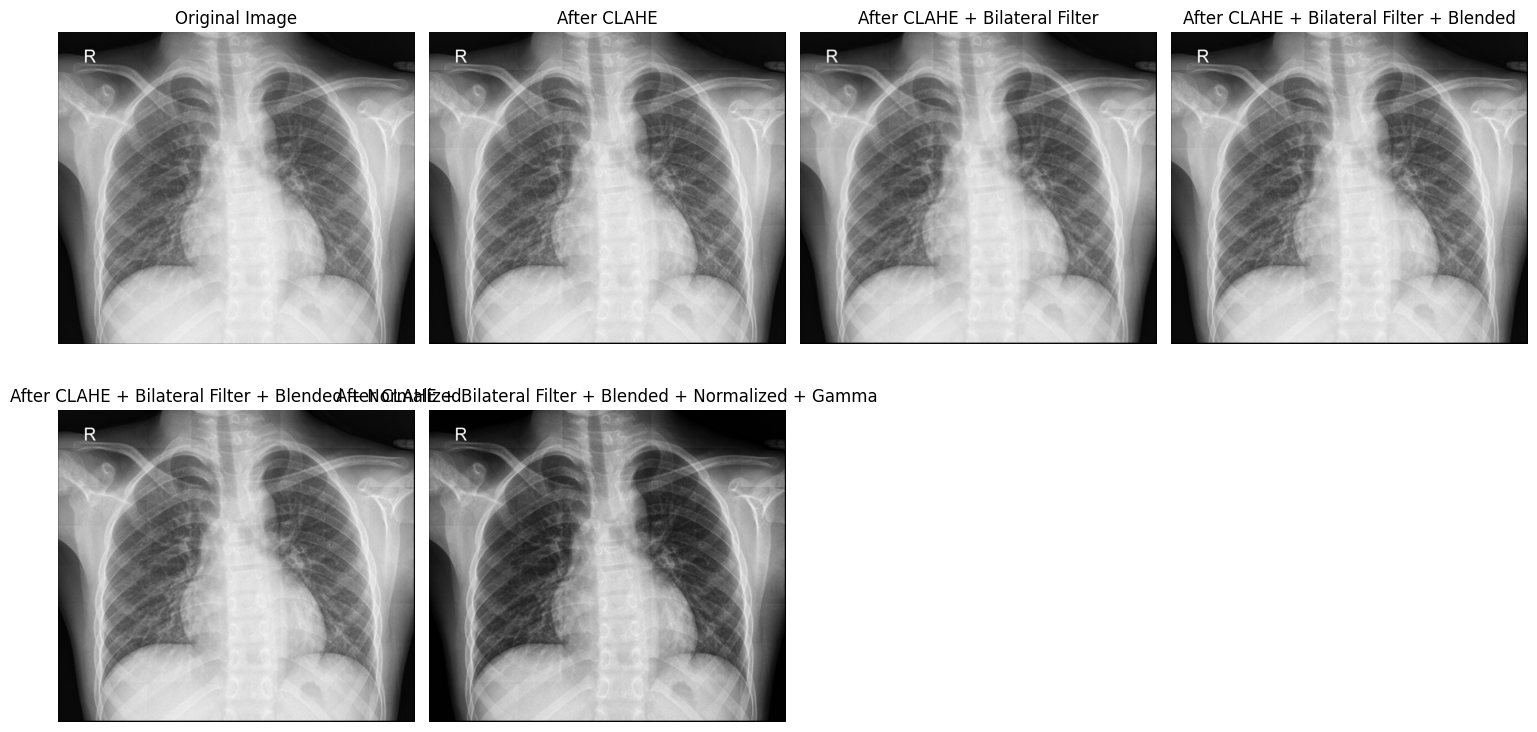

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Suppress deprecation warning

# ---------- Step 0: Load Image ----------
image = imageio.imread("/content/NORMAL2-IM-0664-0001.jpeg", mode='L')
image = (image / image.max() * 255).astype(np.uint8)  # Ensure 8-bit grayscale format

# ---------- Step 1: CLAHE (from scratch) ----------
def clahe_custom(img, tile_grid=(8, 8), clip_limit=40):
    h, w = img.shape
    tile_h, tile_w = h // tile_grid[0], w // tile_grid[1]
    output = np.zeros_like(img)

    for i in range(tile_grid[0]):
        for j in range(tile_grid[1]):
            y1, y2 = i * tile_h, (i + 1) * tile_h
            x1, x2 = j * tile_w, (j + 1) * tile_w
            tile = img[y1:y2, x1:x2]

            hist, _ = np.histogram(tile.flatten(), bins=256, range=[0, 256])

            # Clip histogram
            clipped_hist = np.minimum(hist, clip_limit).astype(np.int32)
            excess = hist - clipped_hist
            redistribute = excess.sum() // 256
            clipped_hist += redistribute

            cdf = clipped_hist.cumsum()
            cdf = 255 * cdf / cdf[-1]
            cdf = cdf.astype('uint8')

            output[y1:y2, x1:x2] = cdf[tile]
    return output

clahe_image = clahe_custom(image)

# ---------- Step 2: Bilateral Filter (from scratch) ----------
def bilateral_filter_custom(img, d=5, sigma_color=75, sigma_space=75):
    assert d % 2 == 1, "Kernel size d must be odd."
    pad = d // 2
    padded = np.pad(img, pad, mode='reflect')
    result = np.zeros_like(img, dtype=float)

    # Pre-compute spatial weights
    x, y = np.meshgrid(np.arange(-pad, pad + 1), np.arange(-pad, pad + 1))
    spatial_weights = np.exp(-(x**2 + y**2) / (2 * sigma_space**2))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded[i:i + d, j:j + d]
            center = padded[i + pad, j + pad]
            intensity_diff = window - center
            color_weights = np.exp(-(intensity_diff**2) / (2 * sigma_color**2))

            total_weights = color_weights * spatial_weights
            total_weights /= np.sum(total_weights)

            result[i, j] = np.sum(total_weights * window)
    return result.astype(np.uint8)

bilateral_image = bilateral_filter_custom(clahe_image)

# ---------- Step 3: Blending ----------
blended_image = (0.8 * clahe_image + 0.2 * bilateral_image).astype(np.uint8)

# ---------- Step 4: Min-Max Normalization ----------
def min_max_normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

normalized_image = min_max_normalize(blended_image)

# ---------- Step 5: Gamma Correction ----------
def gamma_correction(img, gamma):
    return np.power(img, gamma)

gamma = 1.5
gamma_corrected = gamma_correction(normalized_image, gamma)

# Convert back to 8-bit image
final_image = (gamma_corrected * 255).astype(np.uint8)

# ---------- Plotting Each Step ----------
plt.figure(figsize=(15, 8))

# 1. Original Image
plt.subplot(2, 4, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# 2. After CLAHE
plt.subplot(2, 4, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title("After CLAHE")
plt.axis('off')

# 3. After CLAHE + Bilateral Filter
plt.subplot(2, 4, 3)
plt.imshow(bilateral_image, cmap='gray')
plt.title("After CLAHE + Bilateral Filter")
plt.axis('off')

# 4. After CLAHE + Bilateral Filter + Blended
plt.subplot(2, 4, 4)
plt.imshow(blended_image, cmap='gray')
plt.title("After CLAHE + Bilateral Filter + Blended")
plt.axis('off')

# 5. After CLAHE + Bilateral Filter + Blended + Normalized
plt.subplot(2, 4, 5)
plt.imshow((normalized_image * 255).astype(np.uint8), cmap='gray')
plt.title("After CLAHE + Bilateral Filter + Blended + Normalized")
plt.axis('off')

# 6. After CLAHE + Bilateral Filter + Blended + Normalized + Gamma
plt.subplot(2, 4, 6)
plt.imshow(final_image, cmap='gray')
plt.title("After CLAHE + Bilateral Filter + Blended + Normalized + Gamma")
plt.axis('off')

plt.tight_layout()
plt.show()


# **Lung Segmentation + CLAHE**

**Normal**

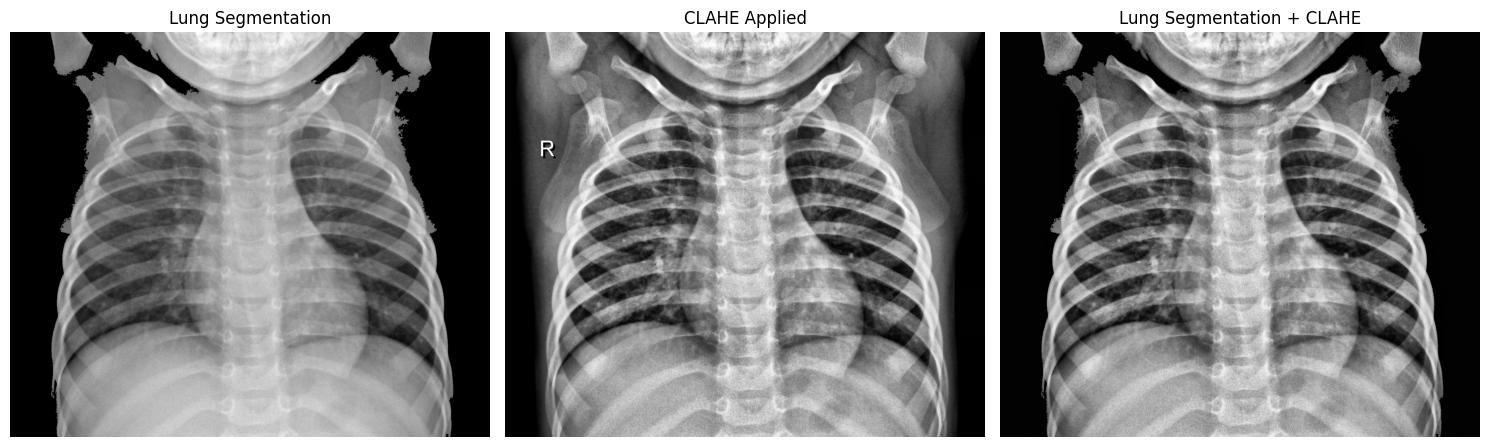

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image = cv2.imread("/content/NORMAL2-IM-0664-0001.jpeg", cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError("Error: Could not read the image. Please check the file path.")

# ------------------- Lung Segmentation ----------------------

def otsu_threshold(image):
    """Compute Otsu's thresholding value"""
    # Calculate histogram
    hist, bins = np.histogram(image.flatten(), 256, [0,256])
    total_pixels = image.size
    sum_total = np.sum(np.arange(256) * hist)  # Weighted sum of the intensity levels

    sum_back = 0
    weight_back = 0
    max_between_var = 0
    threshold = 0

    for t in range(1, 256):
        weight_back += hist[t - 1]
        weight_fore = total_pixels - weight_back
        if weight_back == 0 or weight_fore == 0:
            continue

        sum_back += (t - 1) * hist[t - 1]
        sum_fore = sum_total - sum_back
        mean_back = sum_back / weight_back
        mean_fore = sum_fore / weight_fore

        between_var = weight_back * weight_fore * (mean_back - mean_fore) ** 2

        if between_var > max_between_var:
            max_between_var = between_var
            threshold = t

    return threshold

def connected_components(image):
    """Label connected components in a binary image"""
    label = np.zeros_like(image, dtype=np.int32)  # Change to int32 to avoid overflow
    current_label = 1
    height, width = image.shape

    def bfs(x, y):
        queue = [(x, y)]
        label[x, y] = current_label
        while queue:
            cx, cy = queue.pop(0)
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < height and 0 <= ny < width and image[nx, ny] == 255 and label[nx, ny] == 0:
                    label[nx, ny] = current_label
                    queue.append((nx, ny))

    for i in range(height):
        for j in range(width):
            if image[i, j] == 255 and label[i, j] == 0:
                bfs(i, j)
                current_label += 1

    return label

def lung_segmentation(image):
    """Segment lungs using thresholding and connected components"""
    # Step 1: Apply Otsu's threshold
    threshold = otsu_threshold(image)
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    # Step 2: Perform connected components labeling to find regions (lungs)
    labeled_image = connected_components(binary_image)

    # Step 3: Keep the two largest components (lungs) and mask the image
    unique_labels, counts = np.unique(labeled_image, return_counts=True)
    largest_labels = unique_labels[np.argsort(counts)[-3:]]  # Take the largest 2 components

    mask = np.isin(labeled_image, largest_labels).astype(np.uint8) * 255
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    return segmented_image

# ------------------- CLAHE (Contrast Limited Adaptive Histogram Equalization) ----------------------

def clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE from scratch"""
    # Step 1: Split image into tiles
    tile_height, tile_width = tile_grid_size
    rows, cols = image.shape
    enhanced_image = np.copy(image)

    def equalize_histogram(tile):
        """Apply histogram equalization on a tile"""
        hist, bins = np.histogram(tile.flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf / cdf[-1]  # Normalize the CDF
        cdf_mapped = np.uint8(255 * cdf_normalized)  # Map the CDF to [0,255]
        return cdf_mapped[tile]

    # Step 2: Apply histogram equalization to each tile
    for i in range(0, rows, tile_height):
        for j in range(0, cols, tile_width):
            tile = enhanced_image[i:i + tile_height, j:j + tile_width]
            equalized_tile = equalize_histogram(tile)
            enhanced_image[i:i + tile_height, j:j + tile_width] = equalized_tile

    # Step 3: Clip the contrast by limiting the intensity values
    hist, bins = np.histogram(enhanced_image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    max_cdf = cdf[-1]
    for t in range(0, 256):
        if cdf[t] > clip_limit * max_cdf:
            cdf[t] = clip_limit * max_cdf

    return enhanced_image

# ---- Apply Lung Segmentation ----
segmented_image = lung_segmentation(image)

# ---- Apply CLAHE on Segmented Image ----
clahe_image = clahe(segmented_image)

# ---- Apply CLAHE on Original Image ----
clahe_original_image = clahe(image)

# Display the results
plt.figure(figsize=(15, 5))

# Lung Segmentation result
plt.subplot(1, 4, 1)
plt.imshow(segmented_image, cmap="gray")
plt.title("Lung Segmentation")
plt.axis("off")

# CLAHE result on segmented image
plt.subplot(1, 4, 2)
plt.imshow(clahe_image, cmap="gray")
plt.title("CLAHE on Segmented Image")
plt.axis("off")

# CLAHE result on original image
plt.subplot(1, 4, 3)
plt.imshow(clahe_original_image, cmap="gray")
plt.title("CLAHE on Original Image")
plt.axis("off")

plt.tight_layout()
plt.show()

**Pneumonia**

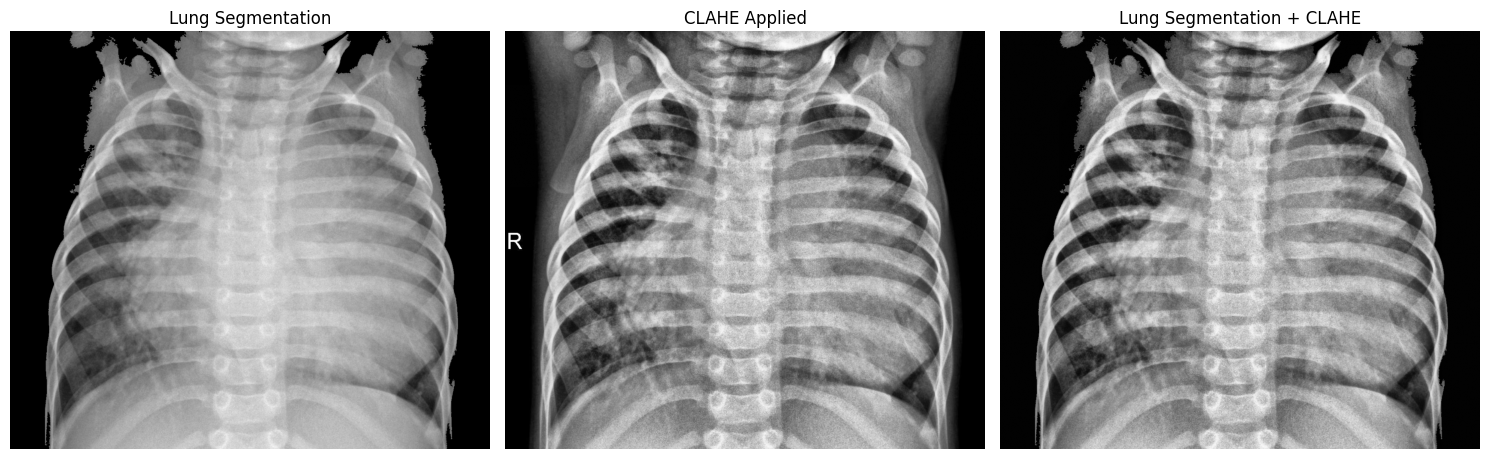

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image = cv2.imread("/content/person80_bacteria_389.jpeg", cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError("Error: Could not read the image. Please check the file path.")

# 📌 Lung Segmentation

def lung_segmentation(image):
    """Basic segmentation using thresholding and contour detection"""
    # Ensure image is of type uint8
    image = image.astype(np.uint8)

    # Threshold to binary image
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours and check if they exist
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image  # Return original image if no contours are found

    # Create a mask and draw the largest 2 contours (lungs)
    mask = np.zeros_like(image, dtype=np.uint8)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    cv2.drawContours(mask, contours, -1, color=255, thickness=-1)

    # Apply mask
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

# 📌 CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Apply lung segmentation
segmented_image = lung_segmentation(image)

# Apply CLAHE
clahe_image = apply_clahe(image)

# Apply both Lung Segmentation and CLAHE
segmented_clahe_image = apply_clahe(segmented_image)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(segmented_image, cmap="gray")
plt.title("Lung Segmentation")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(clahe_image, cmap="gray")
plt.title("CLAHE Applied")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(segmented_clahe_image, cmap="gray")
plt.title("Lung Segmentation + CLAHE")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save final outputs
cv2.imwrite("lung_segmented.jpg", segmented_image)
cv2.imwrite("clahe_applied.jpg", clahe_image)
cv2.imwrite("lung_segmented_clahe.jpg", segmented_clahe_image)


# **Canny Edge Detection**

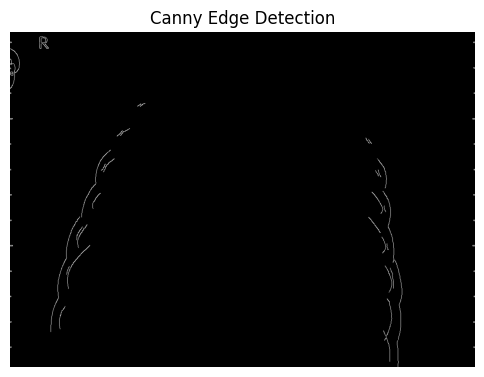

True

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image in grayscale
image = cv2.imread("/content/person80_bacteria_389.jpeg", cv2.IMREAD_GRAYSCALE)

# Check if image is loaded successfully
if image is None:
    raise FileNotFoundError("Error: Image file not found. Check the file path.")

# Apply Canny Edge Detection
edges = cv2.Canny(image, 100, 200)

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()

# Save the output
cv2.imwrite("canny_output.jpg", edges)


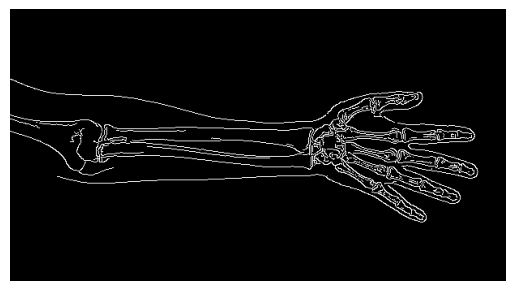

In [ ]:
image=cv2.imread("/content/IVP trials.jpg",cv2.IMREAD_GRAYSCALE)
canny=cv2.Canny(image,100,200)
plt.imshow(canny, cmap="gray")
plt.axis("off")
plt.show()